# Inspect the Data
In this section I will inspect the Data. First I will download and get the data, then get a quick overview of the features and whether all the samples can be used (looking for None values). Looking at the data histogram can inform us whether we need cutoffs and whether we need to shift the data to be closer to a gaussian (closer to gaussian is generally better). We also need to consider how to split the data, whether a clean random split is sufficient or if we need to perform a stratified split.

In [3]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [5]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


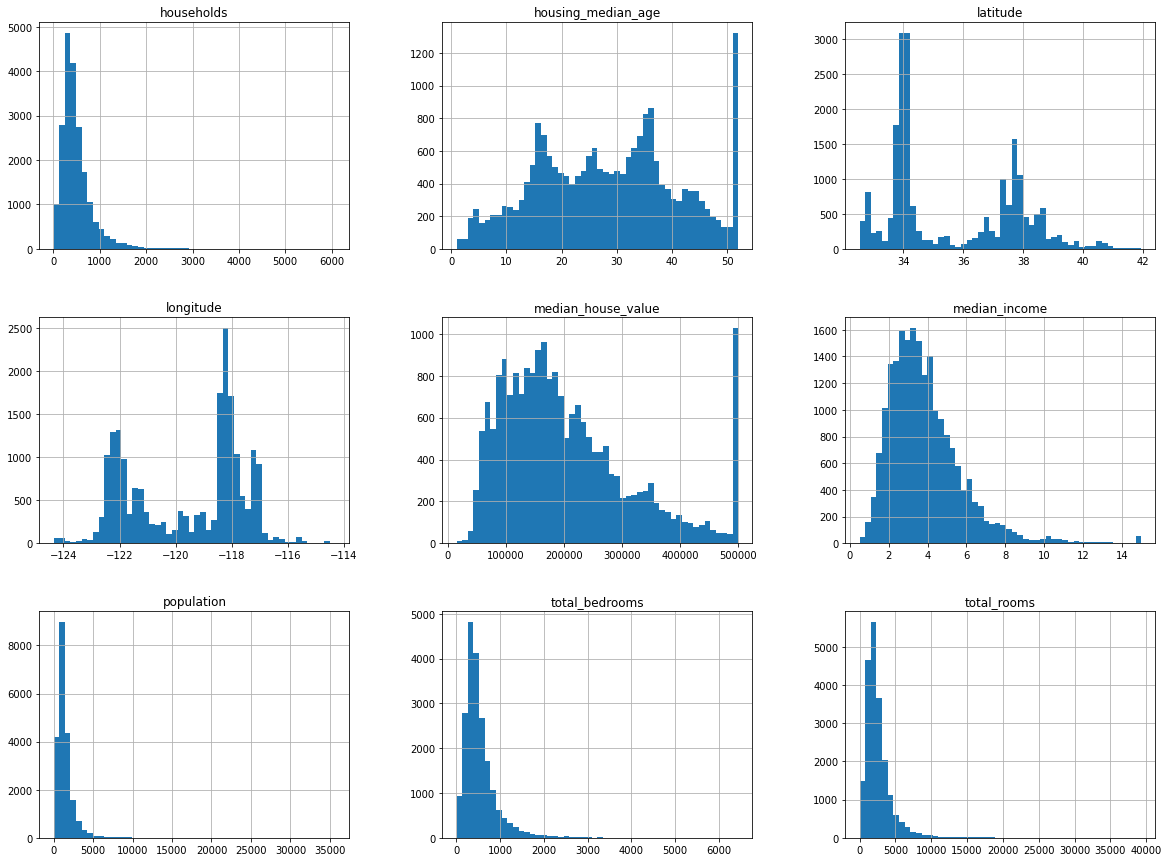

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [14]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

Need to select strata for income. A clever way of selecting will limit bias.

In [18]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

Let's do stratified sampling based on the income category. This is to get a representative selection in the test and train samples to avoid bias in model.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
pd.DataFrame.from_dict({"Tot": housing["income_cat"].value_counts() / len(housing), "Test": strat_test_set["income_cat"].value_counts() / len(strat_test_set), "Train": strat_train_set["income_cat"].value_counts() / len(strat_train_set)})

,Tot,Test,Train
3.0,0.350581,0.350533,0.350594
2.0,0.318847,0.318798,0.318859
4.0,0.176308,0.176357,0.176296
5.0,0.114438,0.114583,0.114402
1.0,0.039826,0.039729,0.039850


In [21]:
test_set.loc[:, "income_cat"] = np.ceil(test_set["median_income"] / 1.5)
test_set["income_cat"].where(test_set["income_cat"] < 5, 5.0, inplace = True)

housing_overall = (housing["income_cat"].value_counts() / len(housing)).sort_index()
rand_test = (test_set["income_cat"].value_counts() / len(test_set)).sort_index()
strat_test = (strat_test_set["income_cat"].value_counts() / len(strat_test_set)).sort_index()
pd.DataFrame.from_dict({"Overall": housing_overall, 
                        "Random": rand_test,
                        "Stratified": strat_test,
                       "Rand. %error": (housing_overall - rand_test)*100,
                       "Strat. %error": (housing_overall - strat_test)*100})

/home/thomas/Documents/Environments/py3_env/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/thomas/Documents/Environments/py3_env/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/thomas/Documents/Environments/py3_env/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,-0.038760,0.009690
2.0,0.318847,0.324370,0.318798,-0.552326,0.004845
3.0,0.350581,0.358527,0.350533,-0.794574,0.004845
4.0,0.176308,0.167393,0.176357,0.891473,-0.004845
5.0,0.114438,0.109496,0.114583,0.494186,-0.014535


Note: assignment is done to a slice. Need to find a good way to solve this.

From this we can see that the stratified split is has a closer distribution compared to the purely random split. Thus stratified split should be used for important categories.

In [22]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Looking at the training set we have chosen
Now that we have seperated the test set we can begin looking at the actual data of the training set. We will look at the values starting with the geography and see if there is any patterns to look for. We will also look at the correlations and see if we can see which features correlates more strongly to the house value. Finally, we will generate a few extra features which hopefully will provide an even stronger correlation than some of the features we already got.

In [23]:
housing = strat_train_set.copy()

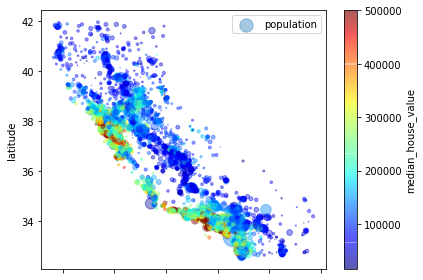

In [24]:
housing.plot(kind = "scatter", x = "longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()
plt.tight_layout()
plt.show()

Value seems to be clustered around high population centers which means we should look at a clustering algorithm. Also, value seems correlated to proximity to the ocean, but with notable exceptions especially in northern California.

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

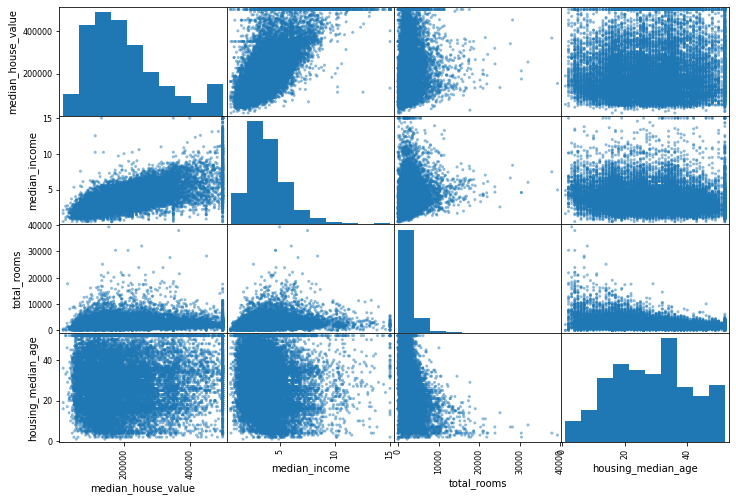

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

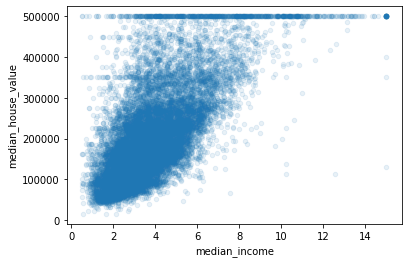

In [27]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms
From now on I will clean the data

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Figuring out what to do with nans. 
We can 
* drop all samples containing nan
* drop all features containing nan
* fill all nans with e.g. mean of rest of the feature

In [30]:
housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

Choosing the last option, we can either use the fillna function from pandas or rely on scikit learn Imputer class.

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

To get the imputed value, we need to drop all non-numerical values

In [32]:
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [33]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
X = imputer.transform(housing_num)

In [36]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# Handling text and categorical attributes
Now we will look at the attribute `ocean_proximity`. Since the attribute is text and categorical, we will change the categories to numericals which can be understood by the computer.

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [38]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Will use onehot encoding instead, since onehot encoding ensures the learning algorithm won't assume each label has anything to do with eachother. Label encoding can be assumed to be similar and category 1 can be seen as close to category 2, which normally is not the case for categories.

In [39]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [40]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

To perform the onehot encoding in one go, use `LabelBinarizer`

In [41]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom Transformers for sklearn
Since sklearn relies on ducktyping it is easy to create custom transformers for sklearn. For some class intended to be made with the sklearn interface, we need three methods: `fit()`, `transform()` and `fit_transform()`. 

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self # nothing else to do
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, household_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Transformation Piplines

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The pipeline lets all transformation be done in one place, which makes toggling hyperparameters easier. For a dataset with both numerical and categorical values we can do the following:

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Trying to fix an error in cat_pipeline:
# LabelBinarizer() is fed an extra argument, so MyLabelBinarizer
# can take three arguments
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [45]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Model selection and training
With ready data we can now select and train a model.

Training a linear regression model

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [211881.21811279 321219.24211009 210877.63065012  62198.25451316
 194847.8414579 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Checking the RMSE to see how well the model is doing

In [48]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.49637588045

Since RMSE for the linear regression model is almost 69000 while the housing costs mostly varies between \\$ 120000 and \\$ 265000, the model has a poor fit.

Let's instead try decision trees.

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Cross-Validation
For better evaluation, use cross-validation to check model performance. The Sklearn function `cross_val_score()` expects a "score", which will be maximized. MSE is a cost function and in this case lower is better. This can be solved by instead of minimizing MSE we will maximize -MSE.

In [50]:
from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                            scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70190.31760171 68364.20511731 71038.66700843 72284.24896627
 69800.08237109 74060.48084461 71813.12103335 70056.30995613
 77590.70343883 70243.58510392]
Mean: 71544.1721441658
Standard deviation: 2503.2010489277204


In [52]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [67458.55176665 67238.28805424 69301.86479972 74738.76571604
 68424.32766462 71629.5382798  65200.14338307 68671.34198073
 72262.43484426 68111.81213342]
Mean: 69303.70686225439
Standard deviation: 2660.958901596759


In [53]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49668.85974031 47723.59286007 49944.00122959 52974.91253523
 49478.51814177 53726.80680874 49181.35782969 47858.34016953
 53488.13187638 50633.9516824 ]
Mean: 50467.847287371624
Standard deviation: 2096.258233689315


For saving the model remember:

In [54]:
import joblib
# use this instead of sklearn.externals import joblib

joblib.dump(forest_reg, "forest_housing.pkl")
# For loading
loaded_forest = joblib.load("forest_housing.pkl")

# Grid Search
For finding optimal hyperparameters, GridSearch can run through possible options in one go and select optimal parameters.

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 90], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 90], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [56]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 90}

For getting the best estimator directly

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Evaluation scores:

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64210.669280831935 {'max_features': 2, 'n_estimators': 3}
55134.8442220903 {'max_features': 2, 'n_estimators': 10}
52623.30737810377 {'max_features': 2, 'n_estimators': 30}
52037.62159415322 {'max_features': 2, 'n_estimators': 90}
60318.05423790005 {'max_features': 4, 'n_estimators': 3}
52707.88276588942 {'max_features': 4, 'n_estimators': 10}
50629.236489242045 {'max_features': 4, 'n_estimators': 30}
49486.32393556067 {'max_features': 4, 'n_estimators': 90}
58653.68840515597 {'max_features': 6, 'n_estimators': 3}
52098.77193484956 {'max_features': 6, 'n_estimators': 10}
49967.57520298116 {'max_features': 6, 'n_estimators': 30}
48993.51513884411 {'max_features': 6, 'n_estimators': 90}
58356.40030730349 {'max_features': 8, 'n_estimators': 3}
51802.37682241468 {'max_features': 8, 'n_estimators': 10}
50351.17088222729 {'max_features': 8, 'n_estimators': 30}
49303.93769586382 {'max_features': 8, 'n_estimators': 90}
62496.26572115004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3

# Analysing the best models
Since we have used random forest it is possible to check which features provide the best predictions.

In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([9.58029899e-02, 8.75458271e-02, 4.18892038e-02, 2.44618364e-02,
       1.92937746e-02, 2.27354630e-02, 1.95349152e-02, 3.00096110e-01,
       9.26588790e-02, 9.87203388e-02, 2.71920084e-02, 2.03795950e-02,
       1.34457170e-01, 7.10018851e-05, 6.55882541e-03, 8.60206183e-03])

In [61]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30009610968194583, 'median_income'),
 (0.1344571699805804, 'INLAND'),
 (0.09872033883858299, 'pop_per_hhold'),
 (0.09580298987181468, 'longitude'),
 (0.09265887897018057, 'rooms_per_hhold'),
 (0.08754582713883657, 'latitude'),
 (0.041889203752315626, 'housing_median_age'),
 (0.027192008441665836, 'bedrooms_per_room'),
 (0.024461836412806998, 'total_rooms'),
 (0.022735462980464315, 'population'),
 (0.02037959501988404, '<1H OCEAN'),
 (0.01953491515779726, 'households'),
 (0.019293774626803324, 'total_bedrooms'),
 (0.008602061829081787, 'NEAR OCEAN'),
 (0.006558825412106279, 'NEAR BAY'),
 (7.100188513347145e-05, 'ISLAND')]

In [63]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

46395.00208091397